## Topic modeling

In [56]:
import numpy as np
import pandas as pd
import sqlite3
from nltk.corpus import stopwords
sw2 = stopwords.words("english")

import matplotlib.pyplot as plt 
import datetime
import time

import gensim
from gensim.models import LdaMulticore, CoherenceModel 
from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.gensim_models

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from pprint import pprint
from collections import Counter
import seaborn as sns

nlp = spacy.load('en_core_web_sm')

Lemmatizer = nlp.get_pipe("lemmatizer")

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Connecting to SQL database

In [34]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect("/Users/xinbu/Desktop/Capstone/repos/um_msba_capstone/ConventionSpeeches.db")
# Extract a dataframe including year, party, and text from the database
full_db = pd.read_sql('SELECT year, party, text FROM conventions;',con)
print(full_db)
# Close the connection
con.close()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


      year       party                                               text
0     2012  Republican  Hey. Delegates, alternates, ladies and gentlem...
1     2012  Republican  Ladies and gentlemen, welcome back to the 2012...
2     2012  Republican  I AM THRILLED TO ADD UTAH'S VOICE IN SUPPORT O...
3     2012  Republican  WOW. WHOO! LOOK AT REPUBLICAN WORK. HELLO, FEL...
4     2012  Republican  GOOD EVENING. MY NAME IS HSER VALENZUELA. TWO ...
...    ...         ...                                                ...
3465  2004  Democratic  THANK YOU. I AM SO THRILLED TO BE HERE TODAY, ...
3466  2004  Democratic  THANK YOU. FIRST, LET ME SAY HOW PROUD WE IN N...
3467  2004  Democratic  I'M REG WEAVER. TONIGHT, I SPEAK TO YOU NOT ON...
3468  2004  Democratic  GOOD EVENING. MY FELLOW DEMOCRATS, AND MY WOND...
3469  2004  Democratic  ALL RIGHT, MICHIGAN. MY FELLOW AMERICANS, MY F...

[3470 rows x 3 columns]


### Data pre-processing

In [35]:
# Make a function preprocess1 and take the dataframe as the parameter
def preprocess1 (db):
    # Drop null values from the dataframe 
    for_modeling_unclean = db.text.dropna()
    for_modeling = []
    # Go through each entry in the text column from the dataframe, convert each entry to lowercase, add to the
    # for_modeling list, return the for_modeling at the end 
    for text in for_modeling_unclean :
        words = [w.lower() for w in text.split()] 
        words = " ".join(words)    
        for_modeling.append(words)
    return for_modeling

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
# Make a function preprocess2, take for_modeling as the parameter 
def preprocess2 (for_modeling): 
    # Update spaCy's default stop words list with my additional words 
    stop_list = ["--","-""!","$","’","#","%","&","'","(",")","*","+","-",".","/",":",";","<","=",">","?","@","[","]","_","`","|","}","~"] 
    nlp.Defaults.stop_words.update(stop_list)

# Iterate over the words in the stop words list and reset the "is_stop" flag
    for word in STOP_WORDS:
        lexeme = nlp.vocab[word]
        lexeme.is_stop = True
    doc_list = []
    allowed_postags=['NOUN','ADJ','VERB','ADV']

# Go through all of the words in each sentence for modeling and only include words with desired posttags 
    for doc in for_modeling :
        # Pass that speech through the pipeline and add to a new list
        pr = nlp(doc)
        doc_list.append([token.lemma_ for token in pr if token.pos_ in allowed_postags and token.text not in stop_list])
    
    return doc_list

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# Make a function preprocess3 and take doc_list as a parameter 
def preprocess3 (doc_list):
    id2word = Dictionary(doc_list)  
    # Get rid of words that occured fewer than 10 times or more than 40% of the time 
    id2word.filter_extremes(no_below=10, no_above=0.4)  
    # Assign new word ids to all words
    id2word.compactify()   
    # Create a corpus of bag-of-words
    corpus = [id2word.doc2bow(word) for word in doc_list] 
    return corpus, id2word

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Make a function trainmodel and take the corpus, id2word, num_topics to use as our LDA model 
def trainmodel (corpus,id2word, num_topics):
    # Train the LDA model on the corpus 
    lda_model = LdaMulticore(corpus=corpus, 
                             id2word=id2word, 
                             num_topics=num_topics, 
                             random_state=1,
                             chunksize=20,
                             passes=40,
                             alpha=0.31,  # set our priors
                             eta=0.91,
                             eval_every=1,
                             per_word_topics=True,
                             workers=1)

    return lda_model

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Descriptive statistics

In [39]:
# Make the function get_patterns, take corpus as a parameter. Get stats on each of the tokens 
def get_patterns(corpus):

    all_desc = corpus
    # Join all sentences to one big string
    all_str = " ".join(all_desc)
    # Take the big string, split to words, and convert to lowercase. Get rid of the stopwords
    clean = [w for w in all_str.split() if w.lower() not in sw2]
    
    # Calculate statistics
    total_tokens = len(clean)
    unique_tokens = len(set(clean))
    clean_tok_len = [len(w) for w in clean]
    avg_token_len = np.mean(clean_tok_len)
    lex_diversity = len(set(clean))/len(clean)
    top_n = Counter(clean).most_common(20)
    
    # Fill out the dictionary 
    results = {'tokens':total_tokens,
               'unique_tokens':unique_tokens,
               'avg_token_length':round(avg_token_len,2),
               'lexical_diversity':round(lex_diversity,2),
               'Top_n':top_n}

    return(results)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
# Use the function to get the patterns and print statistics 
def print_statistics(db,for_modeling):
    print(f'Database: {"{:,}".format(len(db.text))} speeches')
    print(f'Sample for LDA model: {"{:,}".format(len(for_modeling))} speeches')
    print(f'Descriptive stats are:')
    patterns = get_patterns(for_modeling)
    print(patterns)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Probabilities for each category

In [41]:
# Categorize each speech into the topic that is assigned by the LDA model 
def probability_category(for_modeling, lda_model):
    speechlist = []
    categorylist = []
    probabilitylist = []
    topic_assignments = []
    allowed_postags=['NOUN','ADJ','VERB','ADV']

# Calculate topic probabilities for each speech & assign speeches to categories
    for speech in for_modeling :
        doc = [w for w in speech.split()]
        pr = nlp(" ".join(doc))
        doc = [token.lemma_ for token in pr if token.pos_ in allowed_postags]
        doc_new = id2word.doc2bow(doc)

        topic_probs = lda_model[doc_new][0]
        topic = max(topic_probs,key=lambda x: x[1])
        topic_assignments.append(topic[0])    
        prob = max(topic_probs)
        cat = topic[0]
        prob = topic[1]
        speechlist.append(speech)
        categorylist.append(cat)
        probabilitylist.append(prob)

    speeches_df = pd.DataFrame()
    speeches_df["Speech"] = speechlist
    speeches_df["Category"] = categorylist
    speeches_df["Probability"] = probabilitylist
    return speeches_df

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# Find the speech with the highest probability of being in each category
def highestprob(speeches_df,num_topics):
    highestprobs = pd.DataFrame()
    # Loop through each topic
    for item in range(num_topics):  
        # Item gets set to whatever range "numtopics" is set to above, corresponding to the LDA categories
        cat = speeches_df[speeches_df["Category"]==item]  
        # Grab the highest-prob speech for a given category
        item = cat[cat['Probability'] == cat['Probability'].max()]  
        # Grab the speech data
        speech = item["Speech"]  
        # Get category
        category = item["Category"]  
        # Get probability
        probability = item["Probability"]  
        tempdf = pd.DataFrame()
        tempdf["Speech"] = speech
        tempdf["Category"] = category
        # Put speech, category, & probability into a temp dataframe for a given speech
        tempdf["Probability"] = probability  
        # Append that tempdf to "highestprobs" df before iterating again 
        highestprobs = highestprobs.append(tempdf, ignore_index = True)  
    return highestprobs

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Speech counts by category

In [46]:
# Code source: https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin

def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
# Code source 1: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# Code source 2: https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin 
def compute_coherence_values(dictionary, corpus, texts, limit, start, step, party, year):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    LDA_models = {}
    LDA_topics = {}
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, 
                             id2word=dictionary, 
                             num_topics=num_topics, 
                             random_state=1,
                             chunksize=20,
                             passes=40,
                             alpha=0.31,  # set our priors
                             eta=0.91,
                             eval_every=1,
                             per_word_topics=True,
                             workers=1)
        LDA_models[num_topics]=model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        shown_topics = model.show_topics(num_topics=num_topics, 
                                             num_words=10,
                                             formatted=False)
        LDA_topics[num_topics] = [[word[0] for word in topic[1]] for topic in shown_topics]

    # Create a dictionary
    LDA_stability = {}
    # Iterate through each number of the topics
    for i in range(start, limit-1, step):
        # Make a list to store the jaccard_simes
        jaccard_sims = []
        # Iterate through the dictionary for a particular number of topics 
        for t1, topic1 in enumerate(LDA_topics[i]):  
            sims = []
            # Iterate through the dictionary for the number of topics+1 
            for t2, topic2 in enumerate(LDA_topics[i+1]):  
                # Calculate the jaccard_similarity and append it to sims
                sims.append(jaccard_similarity(topic1, topic2))    
            # Make jaccard similarity for topic 1 
            jaccard_sims.append(sims)    
        # Add the jaccard similarities for the number of topics
        LDA_stability[i] = jaccard_sims
    
    coherence_values=coherence_values[:-1]
    # Get the mean of LDA_stability for each number of topics
    mean_stabilities = [np.array(LDA_stability[i]).mean() for i in range (start, limit, step)[:-1]] 
    # Get the coherence value and the conherence minus the mean of stabilities for each number of topics
    coh_sta_diffs = [coherence_values[i] - mean_stabilities[i] for i in range(len(coherence_values))] # limit topic numbers to the number of keywords
    # Get the maximum difference between the coherence value and the mean of stability. 
    coh_sta_max = max(coh_sta_diffs)
    # Get the indexes where the maximum of difference occurs
    coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
    # Choose fewer topics in case there're more than one max
    ideal_topic_num_index = coh_sta_max_idxs[0] 
    # Get the ideal topic number
    ideal_topic_num = ideal_topic_num_index+1
    # Plot the two lines
    x = range(start, limit, step)[:-1] 
    plt.figure(figsize=(20,10))
    ax = sns.lineplot(x=x, y=mean_stabilities, label='Average Topic Overlap')
    ax = sns.lineplot(x=x, y=coherence_values, label='Topic Coherence')

    ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
    ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

    y_max = max(max(mean_stabilities), max(coherence_values)) + (0.10 * max(max(mean_stabilities), max(coherence_values)))
    ax.set_ylim([0, y_max])
    ax.set_xlim([1, limit-1])

    ax.axes.set_title('Model Metrics per Number of Topics '+party+" "+str(year), fontsize=25)
    ax.set_ylabel('Metric Level', fontsize=20)
    ax.set_xlabel('Number of Topics', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()  
    # Return the model with the ideal number of topics and the number of topics
    return LDA_models[ideal_topic_num],ideal_topic_num+1


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Republican-2004
Database: 68 speeches
Sample for LDA model: 68 speeches
Descriptive stats are:
{'tokens': 23508, 'unique_tokens': 6842, 'avg_token_length': 6.28, 'lexical_diversity': 0.29, 'Top_n': [('president', 274), ('bush', 162), ('--', 144), ('thank', 139), ('america', 127), ('us', 119), ('george', 117), ('new', 116), ('great', 113), ('people', 100), ('american', 97), ('one', 96), ('would', 89), ('you.', 88), ('know', 86), ('every', 80), ('years', 75), ('four', 71), ('believe', 71), ('many', 69)]}


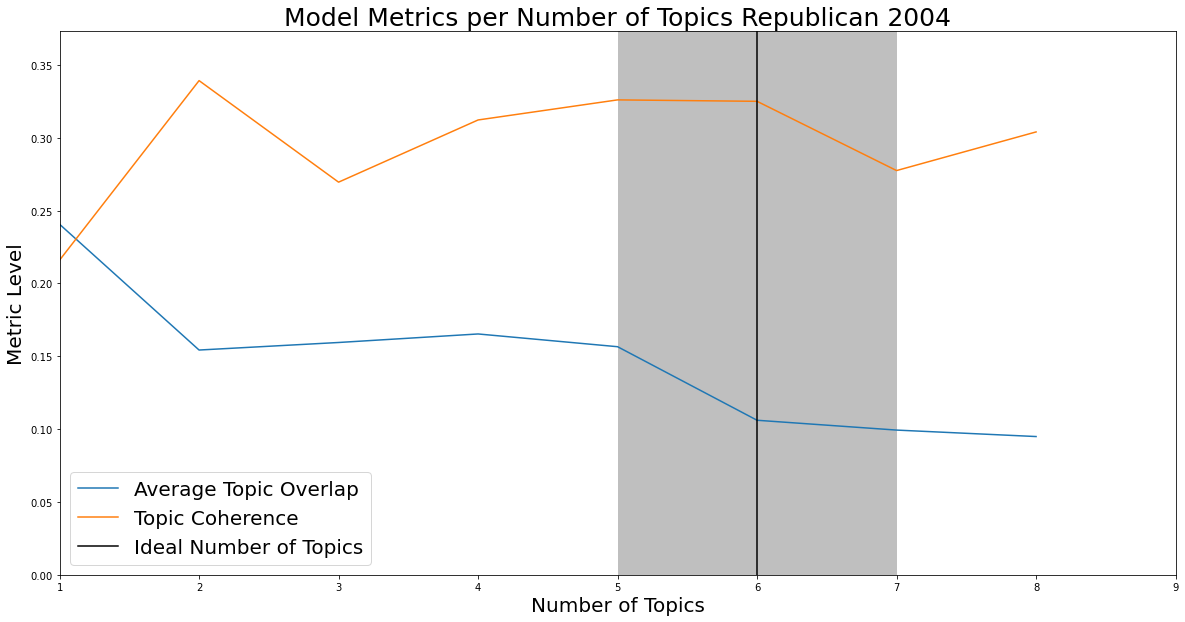

[(0,
  '0.024*"state" + 0.024*"governor" + 0.021*"lady" + 0.020*"young" + '
  '0.019*"give" + 0.019*"opportunity" + 0.018*"welcome" + 0.018*"stand" + '
  '0.016*"convention" + 0.016*"gentleman" + 0.015*"serve" + 0.015*"speak" + '
  '0.013*"proud" + 0.013*"strong" + 0.012*"party" + 0.012*"support" + '
  '0.012*"heart" + 0.012*"courage" + 0.012*"republican" + 0.011*"free"'),
 (1,
  '0.027*"child" + 0.024*"life" + 0.018*"school" + 0.017*"first" + '
  '0.016*"just" + 0.014*"education" + 0.014*"believe" + 0.014*"also" + '
  '0.014*"want" + 0.013*"faith" + 0.012*"leave" + 0.012*"high" + 0.011*"dream" '
  '+ 0.011*"hope" + 0.010*"promise" + 0.010*"parent" + 0.010*"opportunity" + '
  '0.010*"see" + 0.009*"own" + 0.009*"friend"'),
 (2,
  '0.026*"go" + 0.021*"cheer" + 0.020*"tell" + 0.019*"then" + 0.019*"applause" '
  '+ 0.017*"believe" + 0.015*"stand" + 0.015*"world" + 0.014*"want" + '
  '0.014*"back" + 0.012*"see" + 0.012*"war" + 0.011*"be" + 0.011*"get" + '
  '0.010*"freedom" + 0.010*"attack"

<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is d

Republican-2008
Database: 61 speeches
Sample for LDA model: 61 speeches
Descriptive stats are:
{'tokens': 26019, 'unique_tokens': 7056, 'avg_token_length': 6.22, 'lexical_diversity': 0.27, 'Top_n': [('[applause]', 394), ('john', 381), ('mccain', 247), ('--', 228), ('thank', 158), ('people', 131), ('country', 128), ('american', 122), ('know', 118), ('one', 117), ('us', 116), ('would', 107), ('president', 106), ('want', 97), ('america', 96), ('you.', 95), ('great', 94), ('like', 93), ('good', 83), ('government', 76)]}


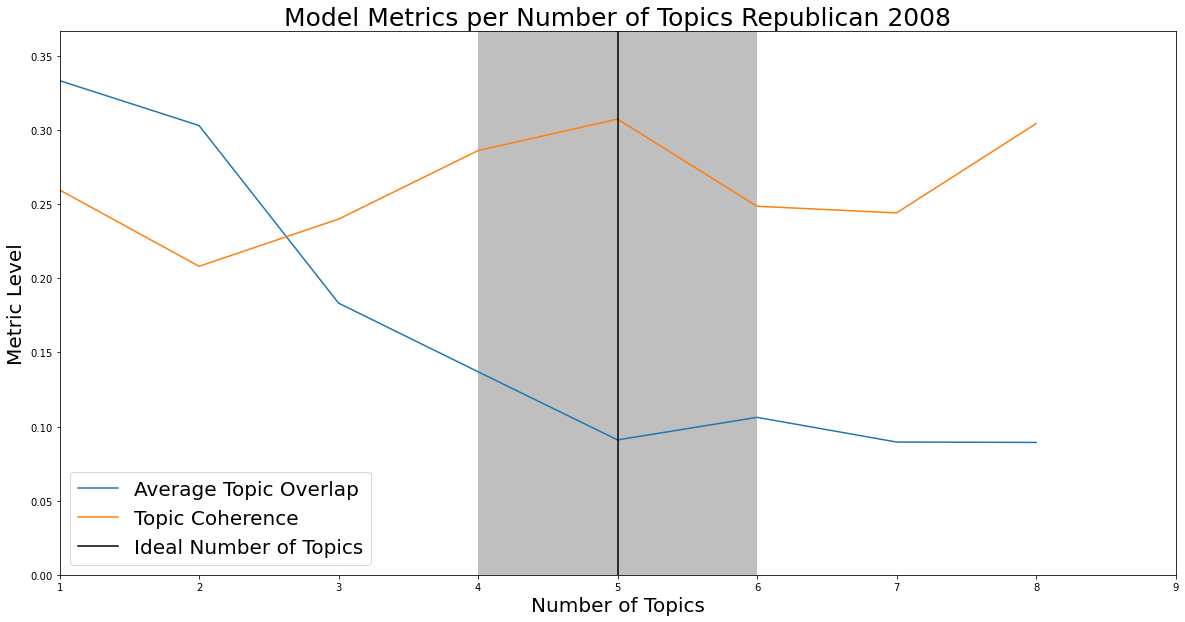

[(0,
  '0.021*"change" + 0.017*"let" + 0.015*"fight" + 0.013*"friend" + 0.012*"job" '
  '+ 0.012*"lead" + 0.012*"win" + 0.010*"keep" + 0.010*"governor" + '
  '0.010*"freedom" + 0.009*"strong" + 0.009*"lose" + 0.009*"big" + '
  '0.009*"vote" + 0.008*"school" + 0.008*"free" + 0.008*"republican" + '
  '0.008*"plan" + 0.008*"experience" + 0.007*"thing"'),
 (1,
  '0.025*"business" + 0.022*"health" + 0.020*"care" + 0.019*"job" + '
  '0.018*"small" + 0.016*"energy" + 0.015*"prosperity" + 0.014*"cost" + '
  '0.014*"create" + 0.013*"taxis" + 0.013*"high" + 0.012*"father" + '
  '0.011*"then" + 0.011*"choice" + 0.010*"applause" + 0.010*"tax" + '
  '0.010*"many" + 0.009*"money" + 0.009*"economy" + 0.009*"individual"'),
 (2,
  '0.034*"man" + 0.019*"fight" + 0.017*"be" + 0.015*"reform" + 0.015*"oil" + '
  '0.015*"election" + 0.015*"small" + 0.014*"thing" + 0.013*"special" + '
  '0.012*"fellow" + 0.012*"energy" + 0.012*"bring" + 0.012*"taxis" + '
  '0.011*"raise" + 0.011*"nominee" + 0.011*"town" + 0.

<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is d

Republican-2012
Database: 91 speeches
Sample for LDA model: 91 speeches
Descriptive stats are:
{'tokens': 34822, 'unique_tokens': 8501, 'avg_token_length': 6.2, 'lexical_diversity': 0.24, 'Top_n': [('mitt', 312), ('president', 265), ('american', 229), ('romney', 212), ('us', 207), ('thank', 202), ('america', 187), ('--', 186), ('know', 174), ('people', 159), ('one', 146), ('like', 141), ('obama', 131), ('great', 130), ('you.', 130), ('get', 119), ('new', 117), ('would', 116), ('government', 116), ('years', 111)]}


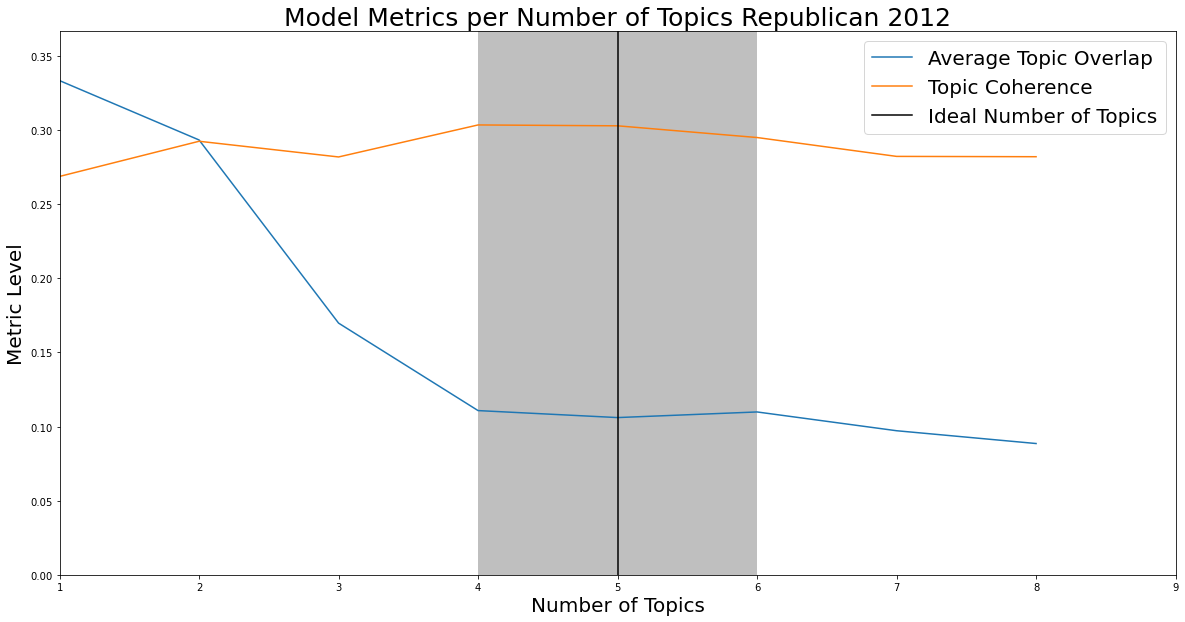

[(0,
  '0.020*"school" + 0.019*"student" + 0.016*"leadership" + 0.014*"stand" + '
  '0.013*"parent" + 0.013*"promise" + 0.013*"olympic" + 0.012*"teacher" + '
  '0.010*"choice" + 0.010*"keep" + 0.010*"hand" + 0.010*"reform" + '
  '0.009*"path" + 0.009*"education" + 0.009*"courage" + 0.009*"election" + '
  '0.009*"high" + 0.009*"opportunity" + 0.009*"generation" + 0.009*"kid"'),
 (1,
  '0.019*"cheer" + 0.018*"applause" + 0.014*"new" + 0.014*"right" + '
  '0.012*"think" + 0.011*"debt" + 0.010*"own" + 0.009*"ask" + '
  '0.008*"administration" + 0.008*"change" + 0.008*"generation" + '
  '0.008*"barack" + 0.008*"turn" + 0.007*"woman" + 0.007*"even" + 0.007*"hope" '
  '+ 0.007*"money" + 0.007*"there" + 0.007*"still" + 0.006*"obama"'),
 (2,
  '0.013*"woman" + 0.013*"convention" + 0.013*"honor" + 0.012*"election" + '
  '0.012*"friend" + 0.011*"care" + 0.010*"city" + 0.010*"right" + '
  '0.010*"welcome" + 0.009*"hear" + 0.009*"fight" + 0.009*"leadership" + '
  '0.008*"serve" + 0.008*"stand" + 0.

<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is d

Republican-2016
Database: 76 speeches
Sample for LDA model: 76 speeches
Descriptive stats are:
{'tokens': 33613, 'unique_tokens': 8560, 'avg_token_length': 6.2, 'lexical_diversity': 0.25, 'Top_n': [('[cheering]', 405), ('donald', 307), ('trump', 245), ('america', 238), ('hillary', 207), ('--', 201), ('us', 198), ('president', 176), ('people', 167), ('know', 163), ('american', 161), ('one', 158), ('country', 149), ('clinton', 140), ('thank', 127), ('make', 126), ('great', 126), ('time', 117), ('like', 117), ('you.', 111)]}


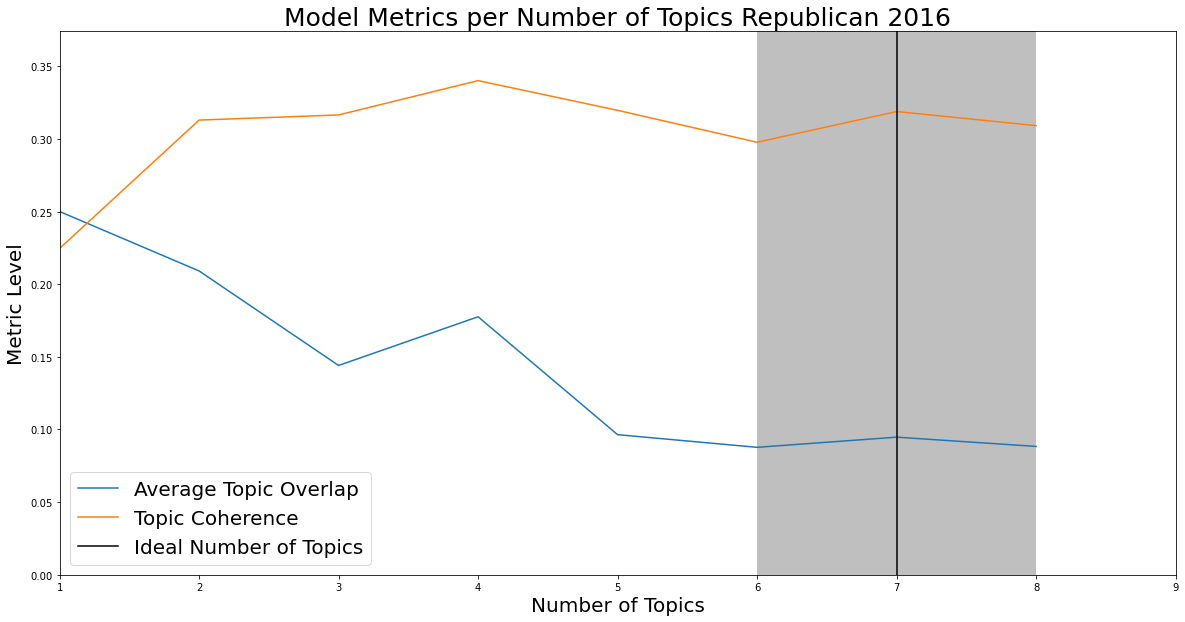

[(0,
  '0.024*"party" + 0.023*"’" + 0.013*"there" + 0.012*"guy" + 0.012*"start" + '
  '0.011*"’s" + 0.010*"still" + 0.010*"idea" + 0.010*"’m" + 0.009*"look" + '
  '0.009*"win" + 0.008*"break" + 0.008*"much" + 0.008*"move" + 0.008*"team" + '
  '0.008*"turn" + 0.007*"hear" + 0.007*"grow" + 0.007*"free" + 0.007*"ready"'),
 (1,
  '0.047*"business" + 0.014*"small" + 0.012*"employee" + 0.012*"future" + '
  '0.011*"understand" + 0.009*"trade" + 0.009*"hear" + 0.009*"republican" + '
  '0.009*"opportunity" + 0.009*"start" + 0.008*"taxis" + 0.008*"high" + '
  '0.008*"pay" + 0.008*"policy" + 0.008*"economy" + 0.008*"regulation" + '
  '0.008*"past" + 0.008*"enough" + 0.007*"create" + 0.007*"plan"'),
 (2,
  '0.018*"challenge" + 0.015*"trust" + 0.014*"community" + 0.012*"help" + '
  '0.012*"leadership" + 0.011*"turn" + 0.011*"understand" + 0.010*"party" + '
  '0.009*"elect" + 0.009*"double" + 0.009*"’s" + 0.009*"cost" + 0.008*"faith" '
  '+ 0.008*"business" + 0.008*"together" + 0.008*"’" + 0.008*"po

<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is d

Republican-2020
Database: 990 speeches
Sample for LDA model: 990 speeches
Descriptive stats are:
{'tokens': 47228, 'unique_tokens': 10683, 'avg_token_length': 6.28, 'lexical_diversity': 0.23, 'Top_n': [('president', 626), ('trump', 424), ('american', 327), ('america', 253), ('people', 223), ('i’m', 209), ('us', 206), ('donald', 188), ('country', 186), ('joe', 183), ('biden', 181), ('like', 180), ('want', 179), ('one', 176), ('every', 168), ('great', 165), ('thank', 165), ('know', 161), ('it’s', 161), ('years', 158)]}


/opt/anaconda3/lib/python3.8/site-packages/gensim/models/ldamodel.py:847: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


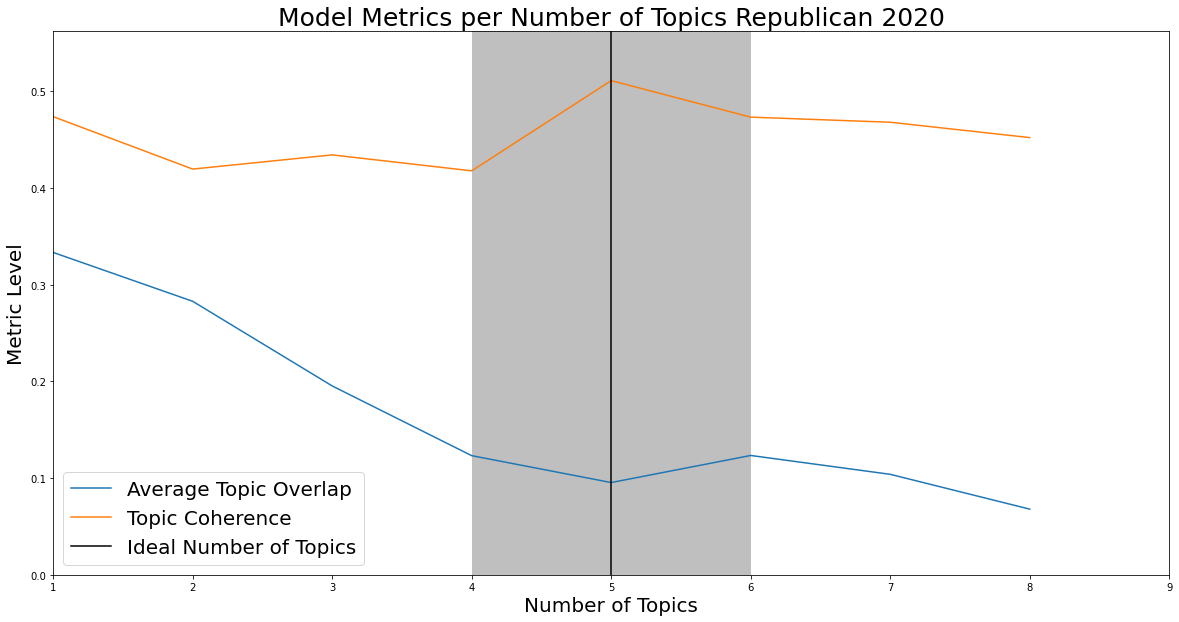

[(0,
  '0.023*"have" + 0.019*"do" + 0.018*"people" + 0.017*"make" + 0.017*"child" + '
  '0.016*"country" + 0.015*"know" + 0.014*"want" + 0.014*"so" + 0.014*"year" + '
  '0.014*"family" + 0.013*"work" + 0.013*"president" + 0.013*"more" + '
  '0.011*"many" + 0.010*"just" + 0.010*"time" + 0.010*"day" + 0.010*"’" + '
  '0.009*"say"'),
 (1,
  '0.015*"year" + 0.015*"american" + 0.015*"trump" + 0.014*"job" + '
  '0.013*"take" + 0.012*"economy" + 0.011*"law" + 0.010*"back" + 0.009*"woman" '
  '+ 0.009*"president" + 0.008*"first" + 0.008*"again" + 0.008*"more" + '
  '0.008*"cut" + 0.008*"radical" + 0.008*"deal" + 0.007*"vote" + 0.007*"world" '
  '+ 0.007*"support" + 0.007*"city"'),
 (2,
  '0.049*"news" + 0.035*"week" + 0.029*"get" + 0.027*"stay" + 0.026*"read" + '
  '0.025*"kind" + 0.024*"night" + 0.023*"most" + 0.023*"’" + 0.023*"form" + '
  '0.023*"important" + 0.023*"complete" + 0.019*"company" + 0.015*"want" + '
  '0.015*"ago" + 0.014*"business" + 0.014*"national" + 0.012*"work" + '
  '0.01

<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is d

Democratic-2004
Database: 184 speeches
Sample for LDA model: 184 speeches
Descriptive stats are:
{'tokens': 63505, 'unique_tokens': 11206, 'avg_token_length': 6.2, 'lexical_diversity': 0.18, 'Top_n': [('john', 1248), ('kerry', 750), ('america', 565), ('thank', 399), ('us', 377), ('president', 364), ('new', 330), ('american', 321), ('make', 296), ('one', 289), ('people', 272), ('--', 272), ('know', 245), ('health', 238), ('you.', 235), ('every', 232), ('united', 223), ('great', 222), ('country', 219), ('edwards', 219)]}


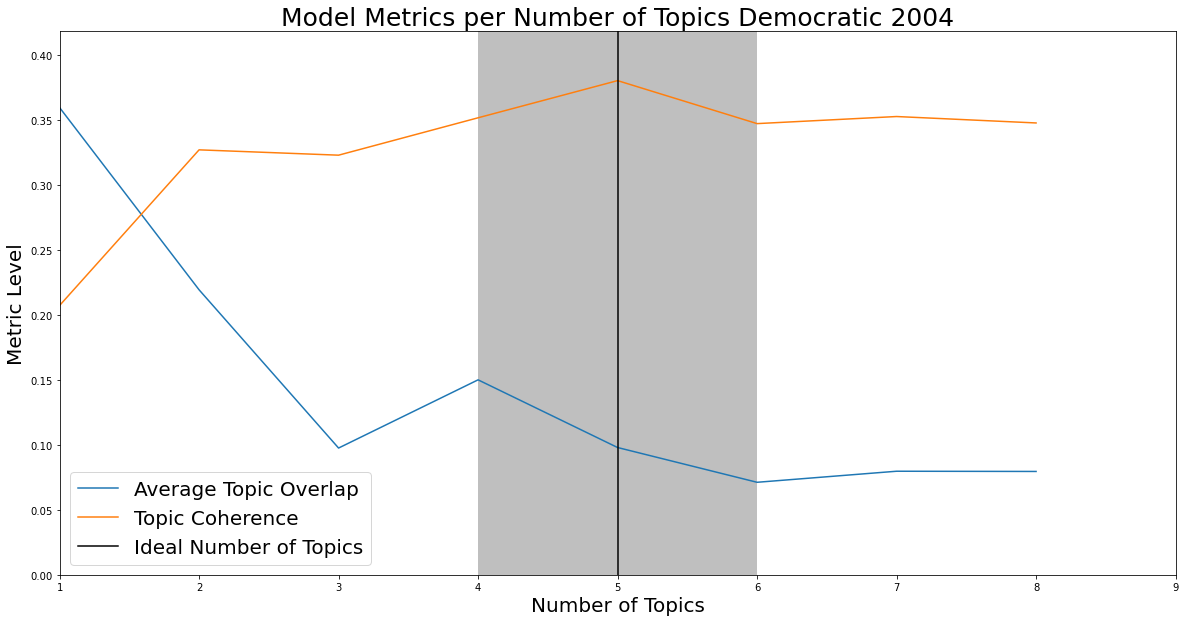

[(0,
  '0.037*"healthcare" + 0.017*"economy" + 0.017*"plan" + 0.016*"city" + '
  '0.015*"cost" + 0.015*"quality" + 0.015*"energy" + 0.014*"affordable" + '
  '0.012*"way" + 0.012*"find" + 0.012*"last" + 0.011*"insurance" + '
  '0.011*"business" + 0.010*"worker" + 0.010*"friend" + 0.009*"pay" + '
  '0.009*"policy" + 0.009*"healthy" + 0.009*"bear" + 0.008*"fellow"'),
 (1,
  '0.013*"party" + 0.010*"woman" + 0.010*"democratic" + 0.008*"vote" + '
  '0.007*"leadership" + 0.007*"friend" + 0.007*"convention" + '
  '0.007*"government" + 0.007*"policy" + 0.007*"proud" + 0.007*"election" + '
  '0.007*"bring" + 0.006*"generation" + 0.006*"win" + 0.006*"power" + '
  '0.006*"celebrate" + 0.006*"protect" + 0.006*"never" + 0.006*"fellow" + '
  '0.005*"history"'),
 (2,
  '0.016*"believe" + 0.010*"hard" + 0.009*"way" + 0.009*"dream" + 0.008*"live" '
  '+ 0.008*"young" + 0.008*"never" + 0.007*"father" + 0.007*"tonight" + '
  '0.007*"be" + 0.007*"pay" + 0.006*"parent" + 0.006*"still" + 0.006*"back" + '
  '

<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is d

Democratic-2008
Database: 113 speeches
Sample for LDA model: 113 speeches
Descriptive stats are:
{'tokens': 43720, 'unique_tokens': 8868, 'avg_token_length': 6.16, 'lexical_diversity': 0.2, 'Top_n': [('barack', 627), ('obama', 510), ('--', 360), ('[applause]', 333), ('us', 280), ('american', 274), ('president', 271), ('john', 247), ('people', 224), ('need', 220), ('change', 219), ('america', 215), ('new', 209), ('mccain', 200), ('years', 193), ('know', 184), ('thank', 182), ('like', 174), ('one', 164), ('every', 163)]}


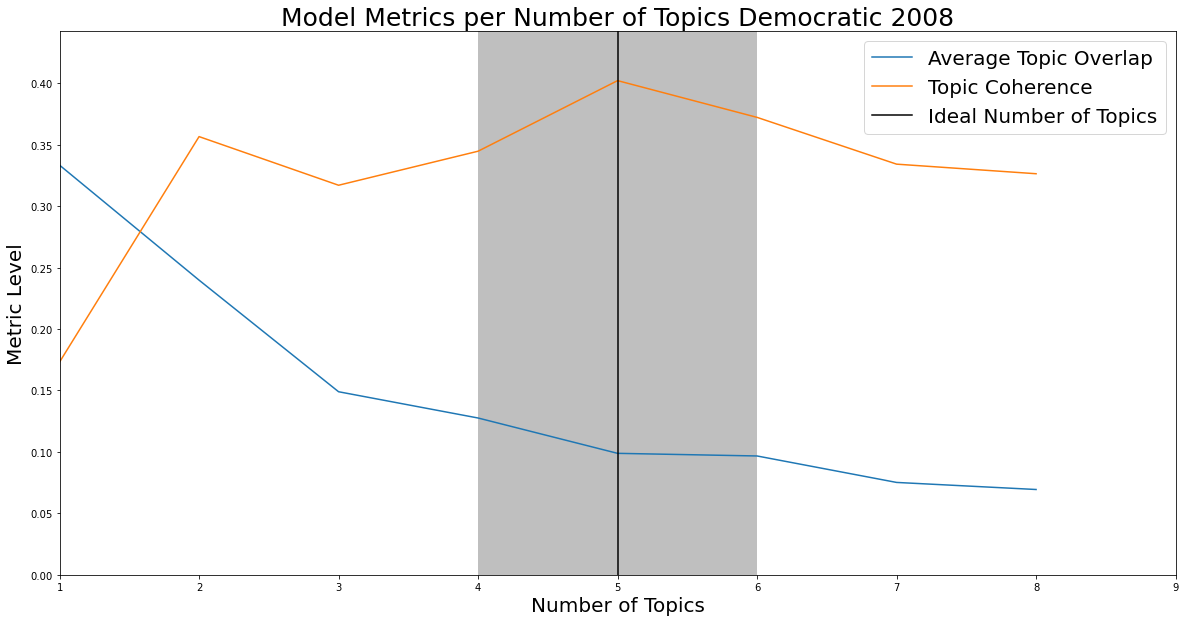

[(0,
  '0.039*"energy" + 0.022*"oil" + 0.012*"create" + 0.012*"tax" + 0.010*"put" + '
  '0.010*"economy" + 0.009*"clean" + 0.009*"future" + 0.008*"invest" + '
  '0.008*"generation" + 0.008*"break" + 0.008*"company" + 0.007*"plan" + '
  '0.007*"high" + 0.007*"as" + 0.007*"green" + 0.007*"fuel" + 0.007*"own" + '
  '0.007*"renewable" + 0.007*"understand"'),
 (1,
  '0.020*"woman" + 0.011*"story" + 0.010*"promise" + 0.009*"mother" + '
  '0.008*"young" + 0.008*"college" + 0.008*"mom" + 0.008*"daughter" + '
  '0.008*"never" + 0.008*"keep" + 0.007*"fight" + 0.007*"love" + '
  '0.007*"parent" + 0.007*"single" + 0.007*"night" + 0.007*"live" + '
  '0.007*"look" + 0.007*"tonight" + 0.007*"applause" + 0.007*"there"'),
 (2,
  '0.011*"war" + 0.010*"leader" + 0.009*"serve" + 0.009*"fight" + '
  '0.008*"elect" + 0.008*"again" + 0.008*"veteran" + 0.008*"lead" + '
  '0.008*"honor" + 0.008*"leadership" + 0.008*"party" + 0.008*"military" + '
  '0.008*"troop" + 0.007*"keep" + 0.007*"very" + 0.007*"woman" + 

<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is d

Democratic-2012
Database: 115 speeches
Sample for LDA model: 115 speeches
Descriptive stats are:
{'tokens': 44434, 'unique_tokens': 9071, 'avg_token_length': 6.2, 'lexical_diversity': 0.2, 'Top_n': [('president', 729), ('obama', 434), ('--', 396), ('[applause]', 313), ('american', 242), ('barack', 232), ('would', 228), ('romney', 216), ('america', 215), ('one', 208), ('us', 203), ('people', 200), ('mitt', 179), ('like', 177), ('know', 175), ('make', 157), ('every', 153), ('work', 150), ('get', 146), ('women', 144)]}


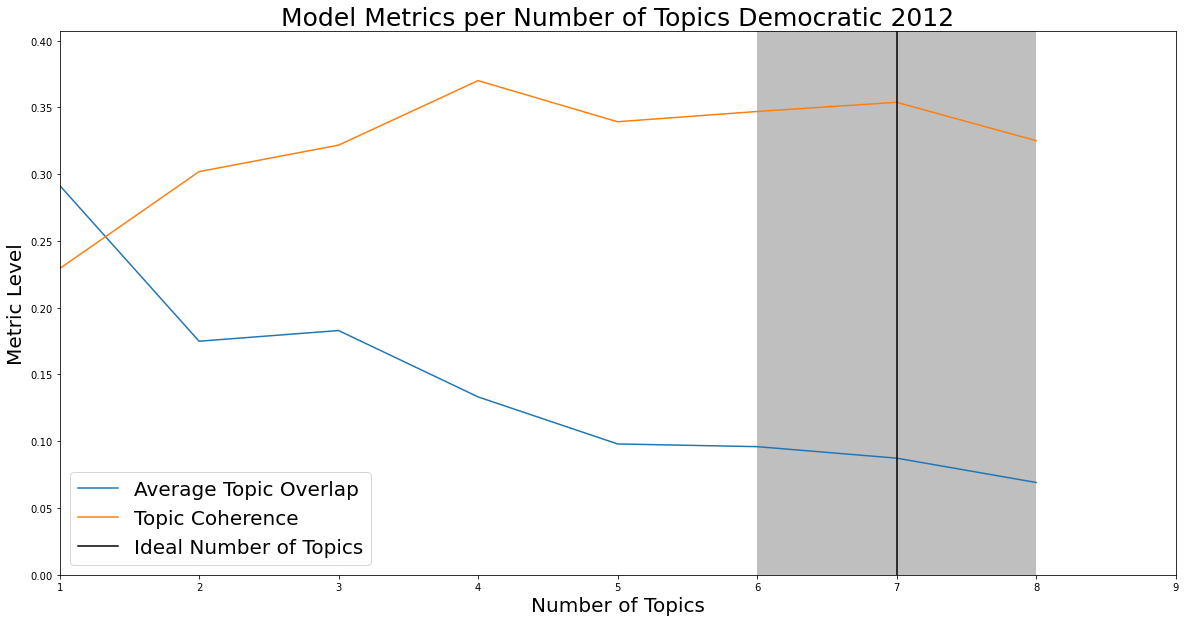

[(0,
  '0.020*"dream" + 0.019*"business" + 0.015*"opportunity" + 0.014*"school" + '
  '0.013*"college" + 0.013*"student" + 0.012*"teacher" + 0.011*"small" + '
  '0.011*"start" + 0.010*"love" + 0.010*"nation" + 0.009*"young" + '
  '0.009*"grow" + 0.008*"there" + 0.007*"ago" + 0.007*"think" + 0.007*"matter" '
  '+ 0.007*"invest" + 0.007*"high" + 0.006*"kid"'),
 (1,
  '0.024*"veteran" + 0.017*"war" + 0.015*"promise" + 0.012*"military" + '
  '0.012*"serve" + 0.011*"service" + 0.011*"world" + 0.010*"vote" + '
  '0.008*"mom" + 0.008*"then" + 0.008*"policy" + 0.008*"leadership" + '
  '0.008*"bless" + 0.007*"choice" + 0.007*"ask" + 0.007*"there" + '
  '0.007*"troop" + 0.007*"generation" + 0.007*"end" + 0.007*"father"'),
 (2,
  '0.018*"new" + 0.016*"energy" + 0.013*"hope" + 0.011*"well" + 0.010*"world" '
  '+ 0.010*"long" + 0.009*"share" + 0.009*"government" + 0.009*"cut" + '
  '0.008*"choose" + 0.008*"tax" + 0.008*"never" + 0.008*"worker" + 0.007*"ask" '
  '+ 0.007*"still" + 0.007*"choice" + 0

<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is d

Democratic-2016
Database: 221 speeches
Sample for LDA model: 221 speeches
Descriptive stats are:
{'tokens': 61064, 'unique_tokens': 11758, 'avg_token_length': 6.15, 'lexical_diversity': 0.19, 'Top_n': [('hillary', 828), ('--', 437), ('clinton', 402), ('people', 328), ('donald', 314), ('know', 306), ('president', 300), ('us', 297), ('trump', 283), ('america', 279), ('like', 279), ('one', 275), ('make', 270), ('every', 260), ('thank', 253), ('get', 218), ('first', 216), ('united', 213), ('[cheers]', 209), ('work', 205)]}


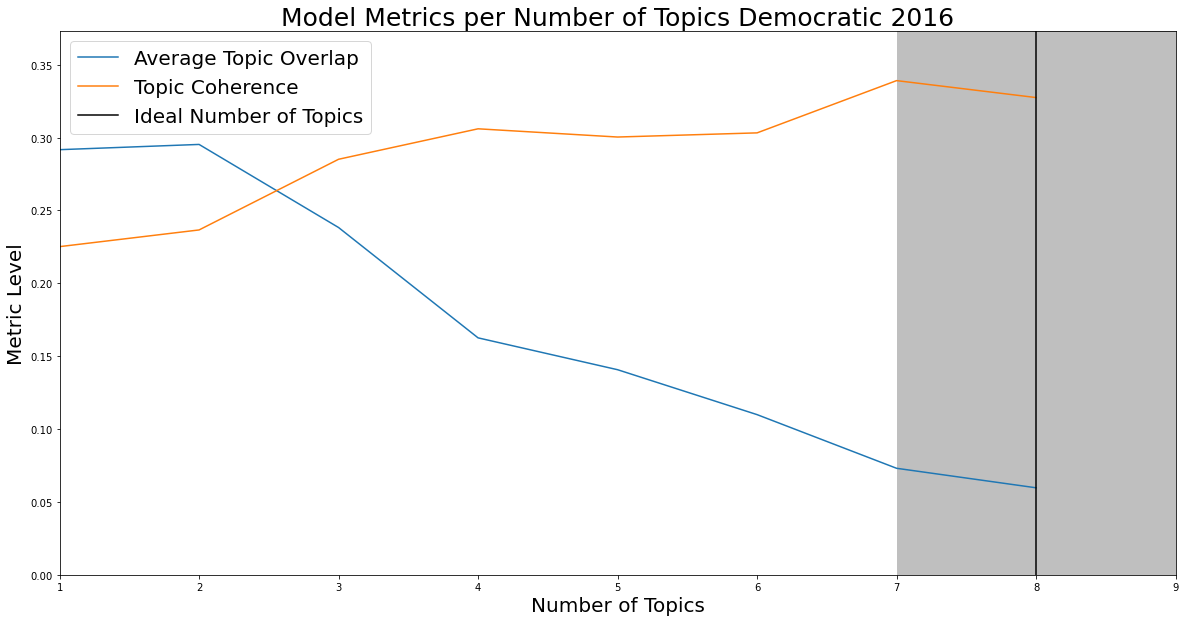

[(0,
  '0.001*"bridge" + 0.001*"november" + 0.001*"congressman" + 0.001*"support" + '
  '0.001*"powerful" + 0.001*"kill" + 0.001*"name" + 0.001*"proud" + '
  '0.001*"immigrant" + 0.001*"speak" + 0.001*"represent" + 0.001*"road" + '
  '0.001*"act" + 0.001*"service" + 0.001*"movement" + 0.001*"form" + '
  '0.001*"living" + 0.001*"member" + 0.001*"understand" + 0.001*"gentleman"'),
 (1,
  '0.023*"election" + 0.020*"cheer" + 0.014*"much" + 0.014*"understand" + '
  '0.012*"wage" + 0.012*"very" + 0.012*"job" + 0.011*"campaign" + '
  '0.011*"health" + 0.010*"justice" + 0.010*"vote" + 0.010*"tonight" + '
  '0.010*"platform" + 0.009*"democratic" + 0.009*"trump" + 0.009*"bring" + '
  '0.009*"future" + 0.009*"million" + 0.009*"care" + 0.009*"let"'),
 (2,
  '0.011*"trump" + 0.009*"job" + 0.009*"tell" + 0.008*"help" + 0.008*"well" + '
  '0.008*"now" + 0.008*"never" + 0.008*"pay" + 0.008*"american" + 0.008*"let" '
  '+ 0.007*"keep" + 0.007*"build" + 0.007*"look" + 0.007*"hard" + 0.007*"care" '
  '+ 

<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is d

Democratic-2020
Database: 1,551 speeches
Sample for LDA model: 1,551 speeches
Descriptive stats are:
{'tokens': 42047, 'unique_tokens': 9416, 'avg_token_length': 6.02, 'lexical_diversity': 0.22, 'Top_n': [('joe', 563), ('us', 318), ('biden', 275), ('president', 261), ('it’s', 255), ('people', 227), ('one', 208), ('i’m', 208), ('like', 180), ('know', 167), ('make', 162), ('that’s', 159), ('get', 158), ('going', 157), ('(', 149), (')', 146), ('need', 139), ('next', 132), ('country', 132), ('biden.', 129)]}


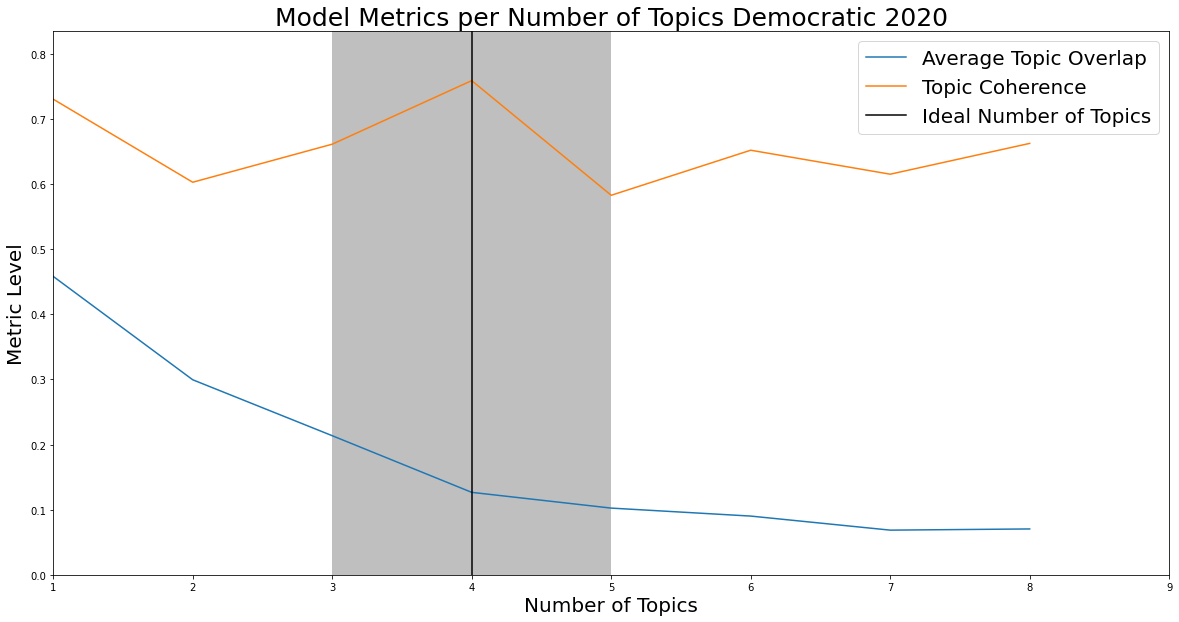

[(0,
  '0.033*"get" + 0.028*"stay" + 0.028*"kind" + 0.028*"’" + 0.027*"most" + '
  '0.026*"week" + 0.025*"want" + 0.025*"read" + 0.022*"enable" + 0.022*"night" '
  '+ 0.022*"important" + 0.021*"form" + 0.019*"speaker" + 0.017*"ago" + '
  '0.017*"convention" + 0.017*"hour" + 0.016*"work" + 0.014*"thank" + '
  '0.012*"national" + 0.010*"democratic"'),
 (1,
  '0.042*"’" + 0.027*"go" + 0.025*"know" + 0.024*"have" + 0.019*"get" + '
  '0.019*"do" + 0.017*"family" + 0.016*"see" + 0.013*"make" + 0.012*"say" + '
  '0.012*"just" + 0.012*"life" + 0.012*"so" + 0.011*"big" + 0.010*"people" + '
  '0.010*"well" + 0.010*"tell" + 0.009*"take" + 0.009*"time" + 0.009*"ask"'),
 (2,
  '0.048*"vote" + 0.030*"job" + 0.022*"plan" + 0.017*"worker" + 0.014*"work" + '
  '0.013*"more" + 0.013*"family" + 0.013*"healthcare" + 0.013*"need" + '
  '0.012*"build" + 0.012*"get" + 0.012*"make" + 0.012*"trump" + '
  '0.012*"million" + 0.012*"have" + 0.011*"climate" + 0.011*"pay" + '
  '0.011*"world" + 0.011*"democracy" + 

<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highestprobs = highestprobs.append(tempdf, ignore_index = True)  # then appends that tempdf to "highestprobs" df before iterating again
<ipython-input-42-7c7ac0d67b04>:14: FutureWarning: The frame.append method is d

In [91]:
# Make the list of parties and years
parties = ['Republican','Democratic']
years = [2004,2008,2012,2016,2020]

# Loop through each year each party
for party in parties:
    for year in years:
        # Print out current year and party
        print(party+"-"+str(year))
        # Get entries for that particular year and party
        db = full_db.loc[(full_db['year']== year)& (full_db["party"]== party)] 
        # Preprocess and get the statistics
        result = preprocess1(db)
        print_statistics(db,result)
        result2 = preprocess2(result)
        result3,id2word = preprocess3(result2)
        # Determine the number of the topics and get the train model with that number of topics
        model, num_topics = compute_coherence_values(id2word, result3, result2, 10, 1, 1,party,year)
        # Print the chosen model
        pprint(model.print_topics(num_words=20))
        print("\n\n")
        # Show each entry of the dataframe and the topic it was assigned to
        pb_df = probability_category(result, model)
        print(pb_df)
        # Get the entry with the highest probability for each topic
        highest_pb_df = highestprob(pb_df,num_topics)
        highest_pb_df= highest_pb_df.rename(columns={"Probability":"Highest_prob"})
        print(highest_pb_df)
        # Prepare model visualization
        pyLDAvis.enable_notebook()
        prepared_data = pyLDAvis.gensim_models.prepare(model,result3,id2word)
        # Save visualization to html document
        pyLDAvis.save_html(prepared_data, party+str(year)+".html")    